# A Markov Chain Matchup Model with Multi-variable Approach
Presented at the SABR Analytics Conference 2023

By Chuqiao(Jeff) Jin, Zexin Chen

In [1]:
%load_ext jupyternotify

# import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import joblib
import importlib

import utils

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
# from scipy.stats import *

pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

In [2]:
utils = importlib.reload(utils)

In [3]:
# pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [5]:
data_df_1522 = pd.read_csv('../data/PitchDataCleanedLean_15-22.csv', index_col=[0])
data_train_df = data_df_1522[data_df_1522['game_year'].isin([2015, 2016, 2017, 2018])].copy()
data_test_df = data_df_1522[data_df_1522['game_year']==2019].copy()

# 1. Justin Verlander vs. Mike Trout Example

## 1.1. Calculate Verlander's Transition Matrix
<div style="display:flex; justify-content: left;">
  <div>
      <table><tr><td style="vertical-align: top;"><center><h3 style="font-size: 20px;">Justin Verlander</h3><p style="font-size: 15px;">MLB ID: 
          434378</p></center></td><td><img src='visuals/verlander_headshot.png' style="width: 250px;"/></td><td><center></center></td></tr></table>
  </div>
</div>

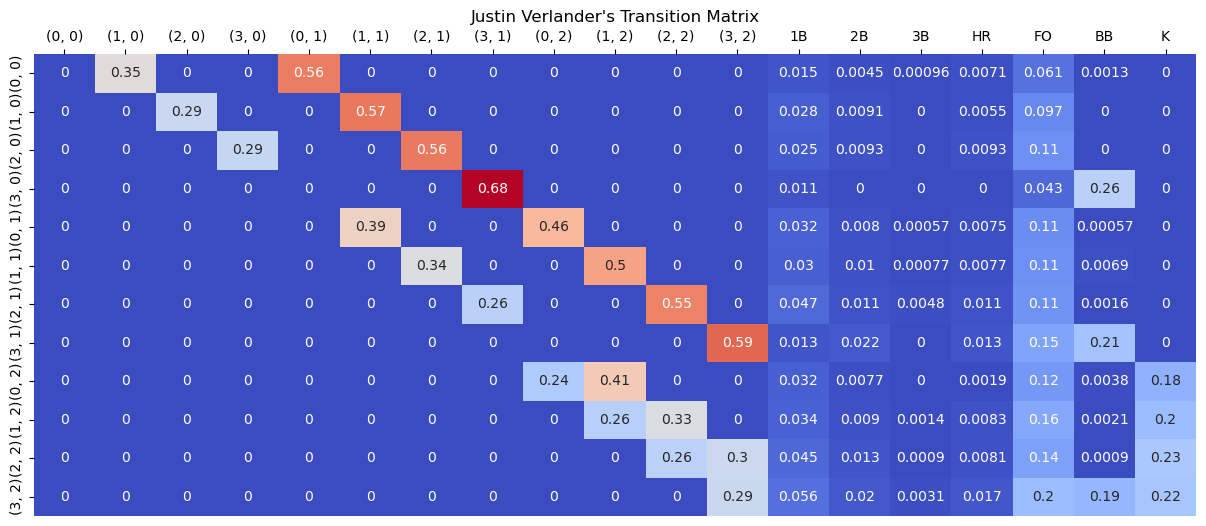

In [6]:
# get Verlander's transition matrix as an array
T_verlander_arr = utils.get_player_T(434378, is_pitcher=True, data_df=data_train_df)
# convert array into df
T_verlander_df = utils.convert_T_df(T_verlander_arr)
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(T_verlander_df[:12], cmap='coolwarm', annot=True, cbar=False)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title("Justin Verlander's Transition Matrix")
plt.show()

## 1.2. Calculate Trout's Transition Matrix
<div style="display:flex; justify-content: left;">
  <div>
      <table><tr><td style="vertical-align: top;"><center><h3 style="font-size: 20px;">Mike Trout</h3><p style="font-size: 15px;">MLB ID: 545361</p>
          </center></td><td><img src='visuals/trout_headshot.png' style="width: 250px;"/></td><td><center></center></td></tr></table>
  </div>
</div>

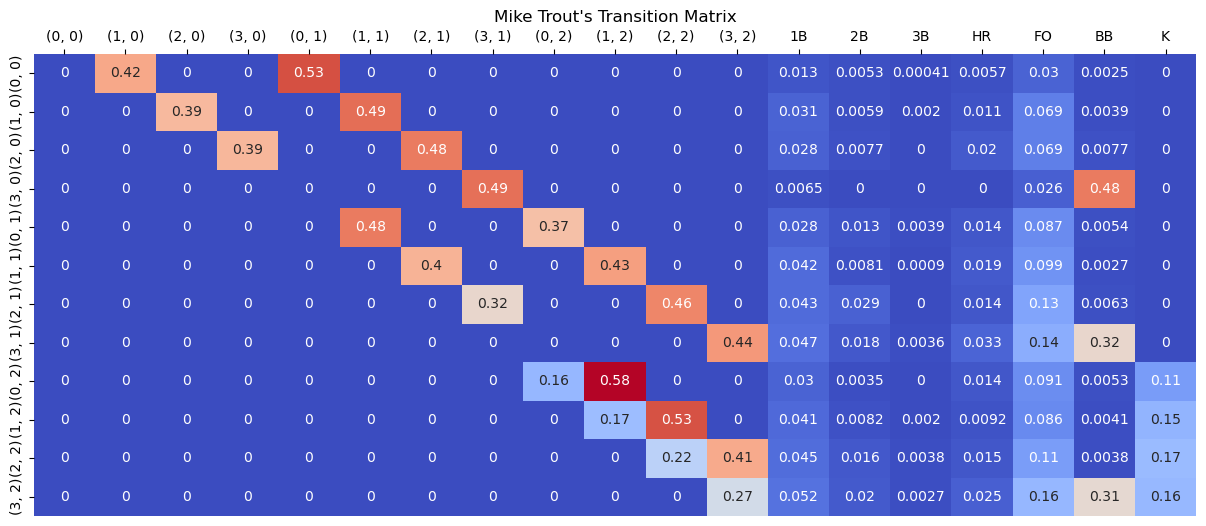

In [7]:
T_trout_arr = utils.get_player_T(545361, is_pitcher=False, data_df=data_train_df)
T_trout_df = utils.convert_T_df(T_trout_arr)
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(T_trout_df[:12], cmap='coolwarm', annot=True, cbar=False)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title("Mike Trout's Transition Matrix")
plt.show()

## 1.3. Calculate Matchup Transition Matrix

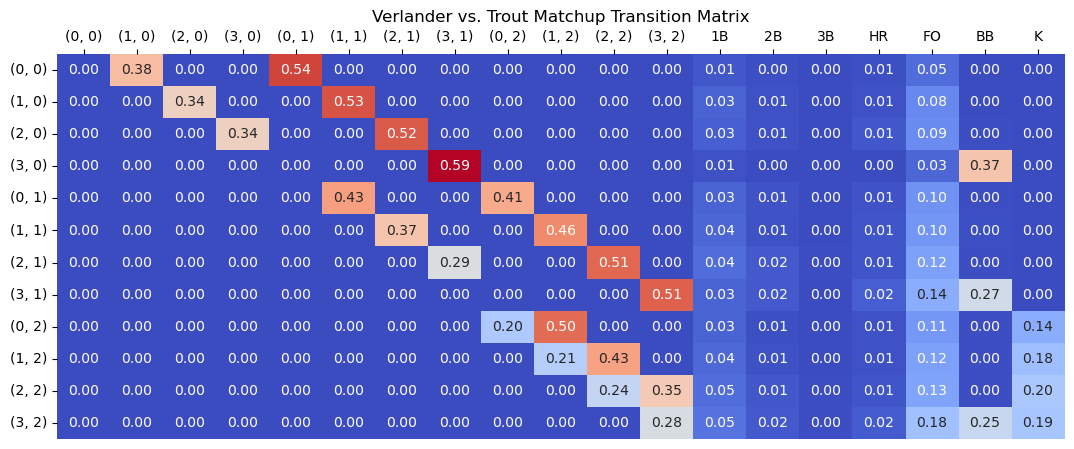

In [8]:
T_matchup_arr = (T_verlander_arr + T_trout_arr) / 2 # Taking the average between T_verlander and T_trout
T_matchup_df = utils.convert_T_df(T_matchup_arr)
fig, ax = plt.subplots(figsize=(13, 5))
sns.heatmap(T_matchup_df[:12], cmap='coolwarm', annot=True, cbar=False, fmt=".2f")
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title("Verlander vs. Trout Matchup Transition Matrix")
plt.show()

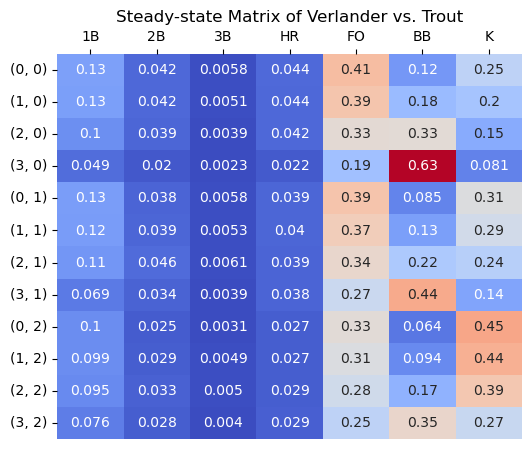

In [9]:
P_matchup_arr = utils.sim_steady_state(T_matchup_arr) # simulate steady-state matrix for matchup
P_matchup_df = utils.convert_T_df(P_matchup_arr)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(P_matchup_df.iloc[:12, 12:], cmap='coolwarm', annot=True, cbar=False)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title("Steady-state Matrix of Verlander vs. Trout")
plt.show()

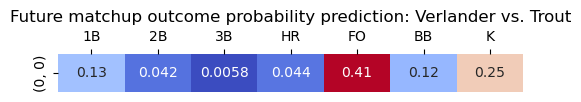

In [10]:
fig, ax = plt.subplots(figsize=(6, 0.5))
sns.heatmap(P_matchup_df.iloc[0:1, 12:], cmap='coolwarm', annot=True, cbar=False)
plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.title("Future matchup outcome probability prediction: Verlander vs. Trout")
plt.show()

# 2. Turner's (Benchmark) Markov Chain Matchup Model Testing
## 2.1. Set PA cutoff for batters and pitchers

In [11]:
batter_min_pa = 400
pitcher_min_pa = 500

pa_batter = data_train_df.groupby(['batter', 'game_pk', 'at_bat_number']).agg({'n_count':sum}).reset_index()
pa_batter['n_count'] = 1
pa_batter = pa_batter.groupby('batter').agg({'n_count':sum}).reset_index()
print(f"Average number of PA per batter: {pa_batter['n_count'].mean():.1f}")

pa_pitcher = data_train_df.groupby(['pitcher', 'game_pk', 'at_bat_number']).agg({'n_count':sum}).reset_index()
pa_pitcher['n_count'] = 1
pa_pitcher = pa_pitcher.groupby(['pitcher']).agg({'n_count':sum}).reset_index().copy()
print(f"Average number of PA per batter: {pa_pitcher['n_count'].mean():.1f}")

# Create qualified players lists
batter_quali_list = pa_batter[pa_batter['n_count']>=batter_min_pa]['batter'].to_list()
pitcher_quali_list = pa_pitcher[pa_pitcher['n_count']>=pitcher_min_pa]['pitcher'].to_list()
print("=======================================")
print(f"Number of qualified batters: {len(batter_quali_list)}")
print(f"Number of qualified pitchers: {len(pitcher_quali_list)}")

Average number of PA per batter: 437.5
Average number of PA per batter: 554.5
Number of qualified batters: 491
Number of qualified pitchers: 487


## 2.2. Calculate all qualified players' transition matrix

In [12]:
# T_batters_dict_1518 = utils.get_allplayers_T(batter_quali_list, data_train_df)
# T_pitchers_dict_1518 = utils.get_allplayers_T(pitcher_quali_list, data_train_df, True)
# # dump transition matrix dicts
# joblib.dump(T_batters_dict_1518, 'T_batters_dict_1518')
# joblib.dump(T_pitchers_dict_1518, 'T_pitchers_dict_1518')

In [13]:
# Load transition matrix dictionaries
T_batters_dict_1518 = joblib.load('T_batters_dict_1518')
T_pitchers_dict_1518 = joblib.load('T_pitchers_dict_1518')

In [14]:
ok = list(T_batters_dict_1518.keys())

## 2.3. Testing on 2019 season data

In [15]:
pa_data_1519 = pd.read_csv('../data/PA_data_merged_15-19_012323.csv', index_col=[0])
pa_data_1519 = pa_data_1519[pa_data_1519['event_type']!='other'].copy() # remove 'other' events
pa_train_df = pa_data_1519[pa_data_1519['game_year'].isin([2015, 2016, 2017, 2018])].copy()
pa_test_df = pa_data_1519[pa_data_1519['game_year']==2019].copy()
pa_test_df = pa_test_df[(pa_test_df['pitcher'].isin(pitcher_quali_list))&(pa_test_df['batter'].isin(batter_quali_list))].copy()

### Log5 Formula
![Log5 Formula](visuals/log5_formula.jpg)

In [16]:
### Log5 Approach ###

batters_odds_dict = {}
pitchers_odds_dict = {}
league_odds_dict = {}
for batter in batter_quali_list:
    batters_odds_dict[batter] = pa_train_df[pa_train_df['batter']==batter]['event_type'].value_counts(normalize=True).to_dict()
    # check if batter has all event types. If not, impute with 0:
    event_missing = [key for key in ['FO', 'K', '1B', 'BB', '2B', 'HR', '3B'] if key not in batters_odds_dict[batter].keys()]
    if event_missing != []:
        for event in event_missing:
            batters_odds_dict[batter][event] = 0.0
    else:
        continue
    
for pitcher in pitcher_quali_list:
    pitchers_odds_dict[pitcher] = pa_train_df[pa_train_df['pitcher']==pitcher]['event_type'].value_counts(normalize=True).to_dict()
    event_missing = [key for key in ['FO', 'K', '1B', 'BB', '2B', 'HR', '3B'] if key not in pitchers_odds_dict[pitcher].keys()]
    if event_missing != []:
        for event in event_missing:
            pitchers_odds_dict[pitcher][event] = 0.0
    else:
        continue
league_odds_dict = pa_train_df['event_type'].value_counts(normalize=True).to_dict()

test_matchup_list = list(zip(pa_test_df['pitcher'], pa_test_df['batter']))

log5_odd_matchup_all = []
for test_matchup in test_matchup_list:
    pitcher = test_matchup[0]
    batter = test_matchup[1]

    log5_odd_matchup = []
    for event_type in utils.EVENT_LIST:
        batter_odd = batters_odds_dict[batter][event_type]
        pitcher_odd = pitchers_odds_dict[pitcher][event_type]
        league_odd = league_odds_dict[event_type]

        log5_odd = ((batter_odd * pitcher_odd)/league_odd)/(((batter_odd * pitcher_odd)/ league_odd) + ((1-batter_odd)*(1-pitcher_odd)/(1-league_odd)))
        log5_odd_matchup.append(log5_odd)
    log5_odd_matchup_all += [log5_odd_matchup]
log5_odd_matchup_all = np.array(log5_odd_matchup_all)
log5_odd_matchup_all = utils.normalize_arr(log5_odd_matchup_all)

b_score_log5 = utils.get_brier_score(pa_test_df[utils.EVENT_LIST].values, log5_odd_matchup_all)

In [17]:
# Pitcher weight = 0.5 (Benchmark MC)
b_score_05 = utils.test_T_dict(data_test_df, T_batters_dict_1518, T_pitchers_dict_1518, p_weight=0.5, _return='score', is_pitch_data=True)

# Pitcher weight = 1 (Pitcher's Avg)
b_score_10 = utils.test_T_dict(data_test_df, T_batters_dict_1518, T_pitchers_dict_1518, p_weight=1, _return='score', is_pitch_data=True)

# Pitcher weight = 0 (Batter's Avg)
b_score_00 = utils.test_T_dict(data_test_df, T_batters_dict_1518, T_pitchers_dict_1518, p_weight=0, _return='score', is_pitch_data=True)

### League Average Prediction ###
T_league = utils.get_league_T(data_df=data_train_df)
P_league = utils.sim_steady_state(T_league)
PA_proba_league = utils.extract_proba(P_league)
PA_proba_league_long = np.tile(PA_proba_league, [len(pa_test_df), 1])
b_score_league = utils.get_brier_score(PA_proba_league_long, pa_test_df[utils.EVENT_LIST ])

### Random Prediction ###
P_rand = np.random.dirichlet(np.ones(7), size=len(pa_test_df))
b_score_rand = utils.get_brier_score(pa_test_df[utils.EVENT_LIST].values, P_rand)

print("Benchmark Test Results")
print(f"Turner (Benchmark MC): {b_score_05:.4f}")
print(f"Pitcher Avg: {b_score_10:.4f}")
print(f"Batters Avg: {b_score_00:.4f}")
print(f"League Average: {b_score_league:.4f}")
print(f"Log5: {b_score_log5:.4f}")
print(f"Random Prediction: {b_score_rand:.4f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Benchmark Test Results
Turner (Benchmark MC): 0.7016
Pitcher Avg: 0.7066
Batters Avg: 0.7027
League Average: 0.7099
Log5: 0.7012
Random Prediction: 0.9639


# 3. Refined MC Model
## 3.1. Test for optimal pitcher's weight

  0%|          | 0/11 [00:00<?, ?it/s]

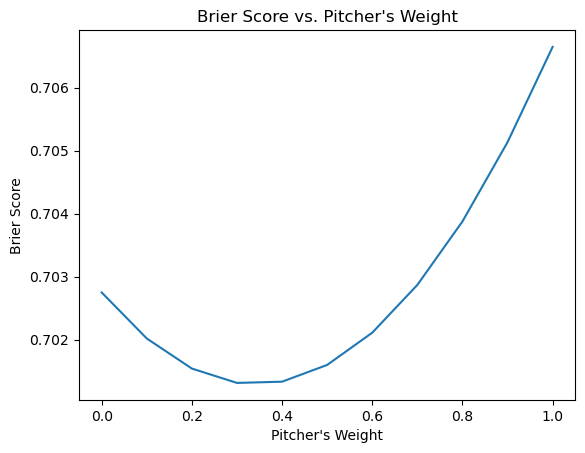

In [18]:
p_weight_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
b_score_dict_1 = utils.test_p_weight(p_weight_list, data_test_df, T_batters_dict_1518, T_pitchers_dict_1518)

sns.lineplot(y=b_score_dict_1.values(), x=b_score_dict_1.keys())
plt.title("Brier Score vs. Pitcher's Weight")
plt.xlabel("Pitcher's Weight")
plt.ylabel("Brier Score")
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

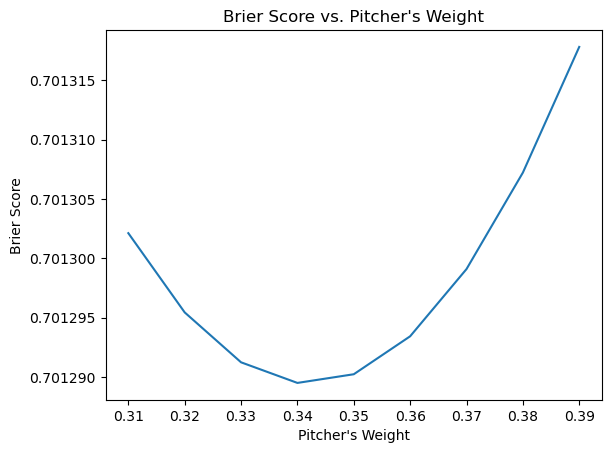

In [19]:
p_weight_list = [0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39]
b_score_dict_2 = utils.test_p_weight(p_weight_list, data_test_df, T_batters_dict_1518, T_pitchers_dict_1518)

sns.lineplot(y=b_score_dict_2.values(), x=b_score_dict_2.keys())
plt.title("Brier Score vs. Pitcher's Weight")
plt.xlabel("Pitcher's Weight")
plt.ylabel("Brier Score")
plt.show()

### Optimal pitcher's weight: 0.34

## 3.2. Add seasonal weight

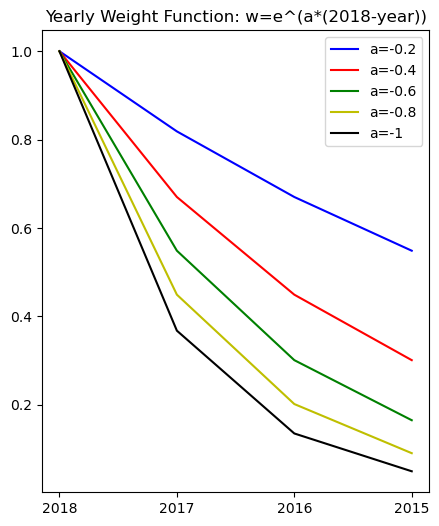

In [20]:
x_list = [x for x in range(4)]
y_list_1 = [np.exp(-0.2*y) for y in x_list]
y_list_2 = [np.exp(-0.4*y) for y in x_list]
y_list_3 = [np.exp(-0.6*y) for y in x_list]
y_list_4 = [np.exp(-0.8*y) for y in x_list]
y_list_5 = [np.exp(-1*y) for y in x_list]

fig, ax = plt.subplots(figsize=[5, 6])
plt.plot(x_list, y_list_1, c='b', label='a=-0.2')
plt.plot(x_list, y_list_2, c='r', label='a=-0.4')
plt.plot(x_list, y_list_3, c='g', label='a=-0.6')
plt.plot(x_list, y_list_4, c='y', label='a=-0.8')
plt.plot(x_list, y_list_5, c='black', label='a=-1')

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['2018', '2017', '2016', '2015'])
ax.legend()
plt.title('Yearly Weight Function: w=e^(a*(2018-year))')
plt.show()

In [21]:
a = -0.2
weight_func = lambda x: np.exp(a*x)
T_batters_weighted_dict_a02 = utils.get_allplayers_T_weighted(batter_quali_list, data_train_df, is_pitcher=False, weight_func=weight_func, cur_year=2018, annual_pa_threshold=70)
T_pitchers_weighted_dict_a02 = utils.get_allplayers_T_weighted(pitcher_quali_list, data_train_df, is_pitcher=True, weight_func=weight_func, cur_year=2018, annual_pa_threshold=150)

a = -0.4
weight_func = lambda x: np.exp(a*x)
T_batters_weighted_dict_a04 = utils.get_allplayers_T_weighted(batter_quali_list, data_train_df, is_pitcher=False, weight_func=weight_func, cur_year=2018, annual_pa_threshold=70)
T_pitchers_weighted_dict_a04 = utils.get_allplayers_T_weighted(pitcher_quali_list, data_train_df, is_pitcher=True, weight_func=weight_func, cur_year=2018, annual_pa_threshold=150)

a = -0.6
weight_func = lambda x: np.exp(a*x)
T_batters_weighted_dict_a06 = utils.get_allplayers_T_weighted(batter_quali_list, data_train_df, is_pitcher=False, weight_func=weight_func, cur_year=2018, annual_pa_threshold=70)
T_pitchers_weighted_dict_a06 = utils.get_allplayers_T_weighted(pitcher_quali_list, data_train_df, is_pitcher=True, weight_func=weight_func, cur_year=2018, annual_pa_threshold=150)

a = -0.8
weight_func = lambda x: np.exp(a*x)
T_batters_weighted_dict_a08 = utils.get_allplayers_T_weighted(batter_quali_list, data_train_df, is_pitcher=False, weight_func=weight_func, cur_year=2018, annual_pa_threshold=70)
T_pitchers_weighted_dict_a08 = utils.get_allplayers_T_weighted(pitcher_quali_list, data_train_df, is_pitcher=True, weight_func=weight_func, cur_year=2018, annual_pa_threshold=150)

a = -1
weight_func = lambda x: np.exp(a*x)
T_batters_weighted_dict_a10 = utils.get_allplayers_T_weighted(batter_quali_list, data_train_df, is_pitcher=False, weight_func=weight_func, cur_year=2018, annual_pa_threshold=70)
T_pitchers_weighted_dict_a10 = utils.get_allplayers_T_weighted(pitcher_quali_list, data_train_df, is_pitcher=True, weight_func=weight_func, cur_year=2018, annual_pa_threshold=150)

b_score_a02 = utils.test_T_dict(data_test_df, T_batters_weighted_dict_a02, T_pitchers_weighted_dict_a02, p_weight=0.34, _return='score')
b_score_a04 = utils.test_T_dict(data_test_df, T_batters_weighted_dict_a04, T_pitchers_weighted_dict_a04, p_weight=0.34, _return='score')
b_score_a06 = utils.test_T_dict(data_test_df, T_batters_weighted_dict_a06, T_pitchers_weighted_dict_a06, p_weight=0.34, _return='score')
b_score_a08 = utils.test_T_dict(data_test_df, T_batters_weighted_dict_a08, T_pitchers_weighted_dict_a08, p_weight=0.34, _return='score')
b_score_a10 = utils.test_T_dict(data_test_df, T_batters_weighted_dict_a10, T_pitchers_weighted_dict_a10, p_weight=0.34, _return='score')

print(f"Seasonally Weighted:")
print(f"a=-0.2:{b_score_a02}")
print(f"a=-0.4:{b_score_a04}")
print(f"a=-0.6:{b_score_a06}")
print(f"a=-0.8:{b_score_a08}")
print(f"a=-1:  {b_score_a10}")

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

Seasonally Weighted:
a=-0.2:0.7012370431169589
a=-0.4:0.7011249217697891
a=-0.6:0.7010563094936725
a=-0.8:0.7010239058186021
a=-1:  0.7010180648468595
